# 課題8: ラベリング
二値化された画像の連結成分にラベルをつけよ。

原画像として https://time-space.kddi.com/freefamily/archives/86 の画像をグレースケール化した画像（図1）を使用する。

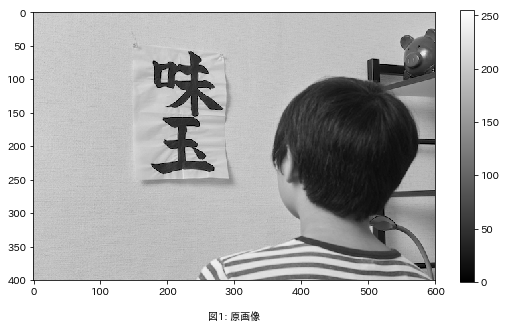

In [1]:
# 環境準備
%run -i prelude.ipynb

# 画像を読み込む
original = PIL.Image.open(IMAGE3_PATH)

# グレースケールに変換
original = np.array(original.convert(mode='L'))

# 表示
def imshow(img, vmax, title):
    fig, ax = plt.subplots(figsize=(9, 5))
    m = ax.imshow(img, cmap='gray', vmin=0, vmax=vmax)
    fig.colorbar(m)
    ax.text(0.5, -0.12, title,
            transform=ax.transAxes,
            horizontalalignment='center',
            verticalalignment='top')

imshow(original, 255, '図1: 原画像')

次に原画像を2値化する。閾値は126とする。原画像において、明るい部分が背景、暗い部分が被写体なので、2値化するにあたって、閾値より明るい画素を0、暗い画素を1とする。2値化結果を図2に示す。

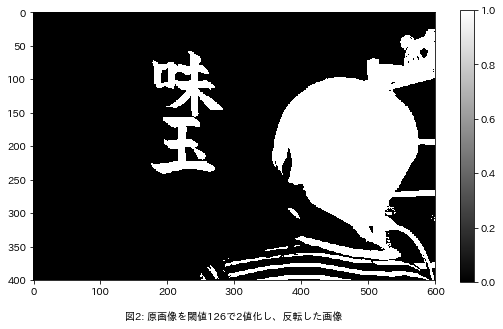

In [2]:
# >= 126 の反転なので < 126
original2 = original < 126
imshow(original2, 1, '図2: 原画像を閾値126で2値化し、反転した画像')

ラベル付けを行うアルゴリズムについて考える。

まず、もっとも簡単な方法は、着目画素から深さ優先探索を行い、到達可能な1-画素に対して、1つのラベルを割り当てる方法である。手順にすると、次の通りである。

1. 出力画像として、入力画像と同じ大きさの画像を作成し、すべての画素を0とする。
2. すべての1-画素 (i, j) について、その画素がラベル付けされていないならば、次の処理を行う。
    1. (i, j) に対して、新しいラベルを割り当て、出力画像の (i, j) 画素をそのラベルにする。
    2. 4-隣接、または8-隣接画素のうち、1-画素 (k, l) について、出力画像の (k, l) 画素をそのラベルにする。
    3. 4-隣接、または8-隣接画素のうち、1-画素 (k, l) について、 (i, j) <- (k, l) として、B、Cを行う。
    
しかし、この方法を原画像に対して行ったところ、スタックオーバーフローが発生してしまった。

そこで、次の方法でラベル付けを行うことにした。

1. 出力画像として、入力画像と同じ大きさの画像を作成し、すべての画素を0とする。
2. 水平走査、垂直走査の順のラスタ走査で画素を処理する。そのときの着目画素を (i, j) とする。 (i, j) が1-画素ならば
    1. 着目画素の上、左（8-連結ならば、さらに左上、右上）の画素のうち1-画素のラベル（出力画像に記録されている）を調べる。
    2. それらのラベルは、同じラベルであると記録し、着目画素にもそのラベルを割り当てる。もし、調べた隣接画素がすべて0-画素ならば、新しいラベルを割り当てる。
    3. (i, j) に割り当てたラベルを出力画像に記録する。
3. 同じラベルであると記録した情報を用いて、再度ラベルを連番で振り直し、出力画像もそれに対応して更新する。

同じラベルとして記録する方法として、 Union-Find 法を用いる。このアルゴリズムで、ラベル付けを行うプログラムを、関数 label として示す。

In [3]:
def label(img, connect8):
    """
    img にラベル付けを行った結果を出力する。
    connect8 が False なら 4 連結、 True なら 8 連結で求める。
    """
    
    # 入力と同じ大きさの画像を作成
    output = np.zeros(img.shape, dtype=np.uint)
    
    # ラベルを記録する Union-Find 木
    # 0-画素のラベルを0とする
    labels = [0]
    
    # x が属するラベル（Union-Find 木の根）を求める
    def find(x):
        if labels[x] != x:
            labels[x] = find(labels[x])
        return labels[x]
    
    # x と y を同じラベルとして記録する
    def union(x, y):
        x = find(x)
        y = find(y)
        if x != y:
            labels[y] = x
    
    # 左上から右下に探索
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j]:
                # 着目画素 (i, j) が1ならば、周囲の画素を探索
                # この画素より右と下は未探索なので、探索しない

                # 着目画素と (k, l) が1ならば、連結していることを記録
                def connect(k, l):
                    nonlocal ij_label
                    
                    # (k, l) が範囲外か、その画素が 0 なら、何もしない
                    out_of_range = k < 0 or k >= img.shape[0] or l < 0 or l >= img.shape[1]
                    if out_of_range or not img[k, l]:
                        return

                    # (k, l) のラベルを取得
                    kl_label = output[k, l]
                    # (k, l) はすでにラベル付けされているはず（バグチェック）
                    assert kl_label > 0

                    if ij_label is None:
                        # まだ着目画素のラベルが決まっていないなら
                        # 着目画素は (k, l) と同じラベルとする
                        ij_label = kl_label
                    else:
                        # すでに着目画素のラベルが決まっているなら
                        # そのラベルと (k, l) のラベルは同じラベルとして記録する
                        union(ij_label, kl_label)

                # 最初はラベル不明としておく
                ij_label = None

                # 4近傍のうち探索できるもの
                connect(i - 1, j) # 上
                connect(i, j - 1) # 左

                # 8近傍のうち探索できるもの
                if connect8:
                    connect(i - 1, j - 1) # 左上
                    connect(i - 1, j + 1) # 右上

                # どの近傍画素もラベル付けされていないならば
                # 新しいラベルとして記録
                if ij_label is None:
                    ij_label = len(labels)
                    labels.append(ij_label)

                # ラベルを出力に記録
                output[i, j] = ij_label
                
    reduced_labels = [None] * len(labels)
    reduced_label_n = 0
    
    # 根に連番を振っていく
    for i in range(len(labels)):
        if i == labels[i]:
            reduced_labels[i] = reduced_label_n
            reduced_label_n += 1
        
    # 根以外が連番を指すようにする
    for i in range(len(labels)):
        if i != labels[i]:
            reduced_labels[i] = reduced_labels[find(i)]
            
    # 出力画像を新たに振り直したラベルに書き換え
    for (i, j) in np.ndindex(output.shape):
        output[i, j] = reduced_labels[output[i, j]]
        
    return output

この方法を用いて、4-連結でラベル付けを行った結果を図3に、8-連結でラベル付けを行った結果を図4に示す。

ラベル数: 50


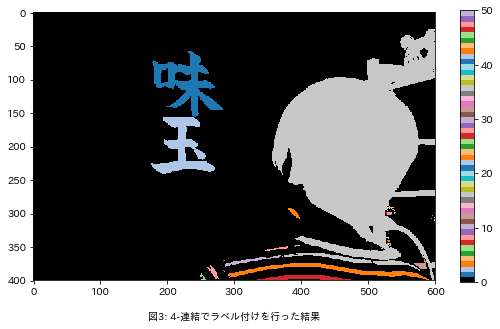

In [4]:
# 4-連結でラベル付け
img_4connected = label(original2, False)

print('ラベル数:', np.max(img_4connected))

# 表示
def labelshow(labeled_img, title):
    # 0は黒、それ以外は tab20 を繰り返して使う
    base_cm = plt.get_cmap('tab20').colors
    colors = ['black']
    for i in range(1, np.max(labeled_img) + 1):
        colors.append(base_cm[(i - 1) % len(base_cm)])
        
    fig, ax = plt.subplots(figsize=(9, 5))
    m = ax.imshow(labeled_img, cmap=matplotlib.colors.ListedColormap(colors))
    fig.colorbar(m)
    ax.text(0.5, -0.12, title,
            transform=ax.transAxes,
            horizontalalignment='center',
            verticalalignment='top')

labelshow(img_4connected, '図3: 4-連結でラベル付けを行った結果')

ラベル数: 36


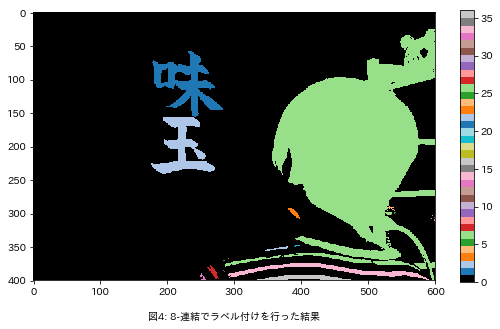

In [5]:
# 8-連結でラベル付け
img_8connected = label(original2, True)
print('ラベル数:', np.max(img_8connected))
labelshow(img_8connected, '図4: 8-連結でラベル付けを行った結果')

図3、図4では、髪や「味玉」という文字を、それぞれ1つの連結成分として切り出すことができていることが確認できた。

4-連結では、ラベル数（連結成分数）が50個、8-連結では36個という結果が得られた。図3、図4をぱっと見ただけでは、ラベル付けの結果の違いを読み取ることができないので、ノイズのような細かい点で構成される連結成分の連結で、4-連結と8-連結の差が表れているのだと考えられる。